In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
import joblib
import h5py

In [2]:
nRowsRead = 70000
df = pd.read_csv(r"C:\Users\parth.parikh1\Documents\Project\employee_reviews.csv", delimiter=',', nrows=nRowsRead, encoding='latin1')

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow  # Integer division using //
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    nGraphShown = min(nCol, math.ceil(nGraphShown))  # Ensure nGraphShown is a positive integer
    for i in range(nGraphShown):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [4]:
df.drop('helpful-count', axis=1, inplace=True)

In [5]:
df.head(5)

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5,4,5,5,4,5,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4,2,3,3,5,3,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5,5,4,5,5,4,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5,2,5,5,4,5,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5,5,5,5,5,5,https://www.glassdoor.com/Reviews/Google-Revie...


In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [8]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 67529 rows and 16 columns


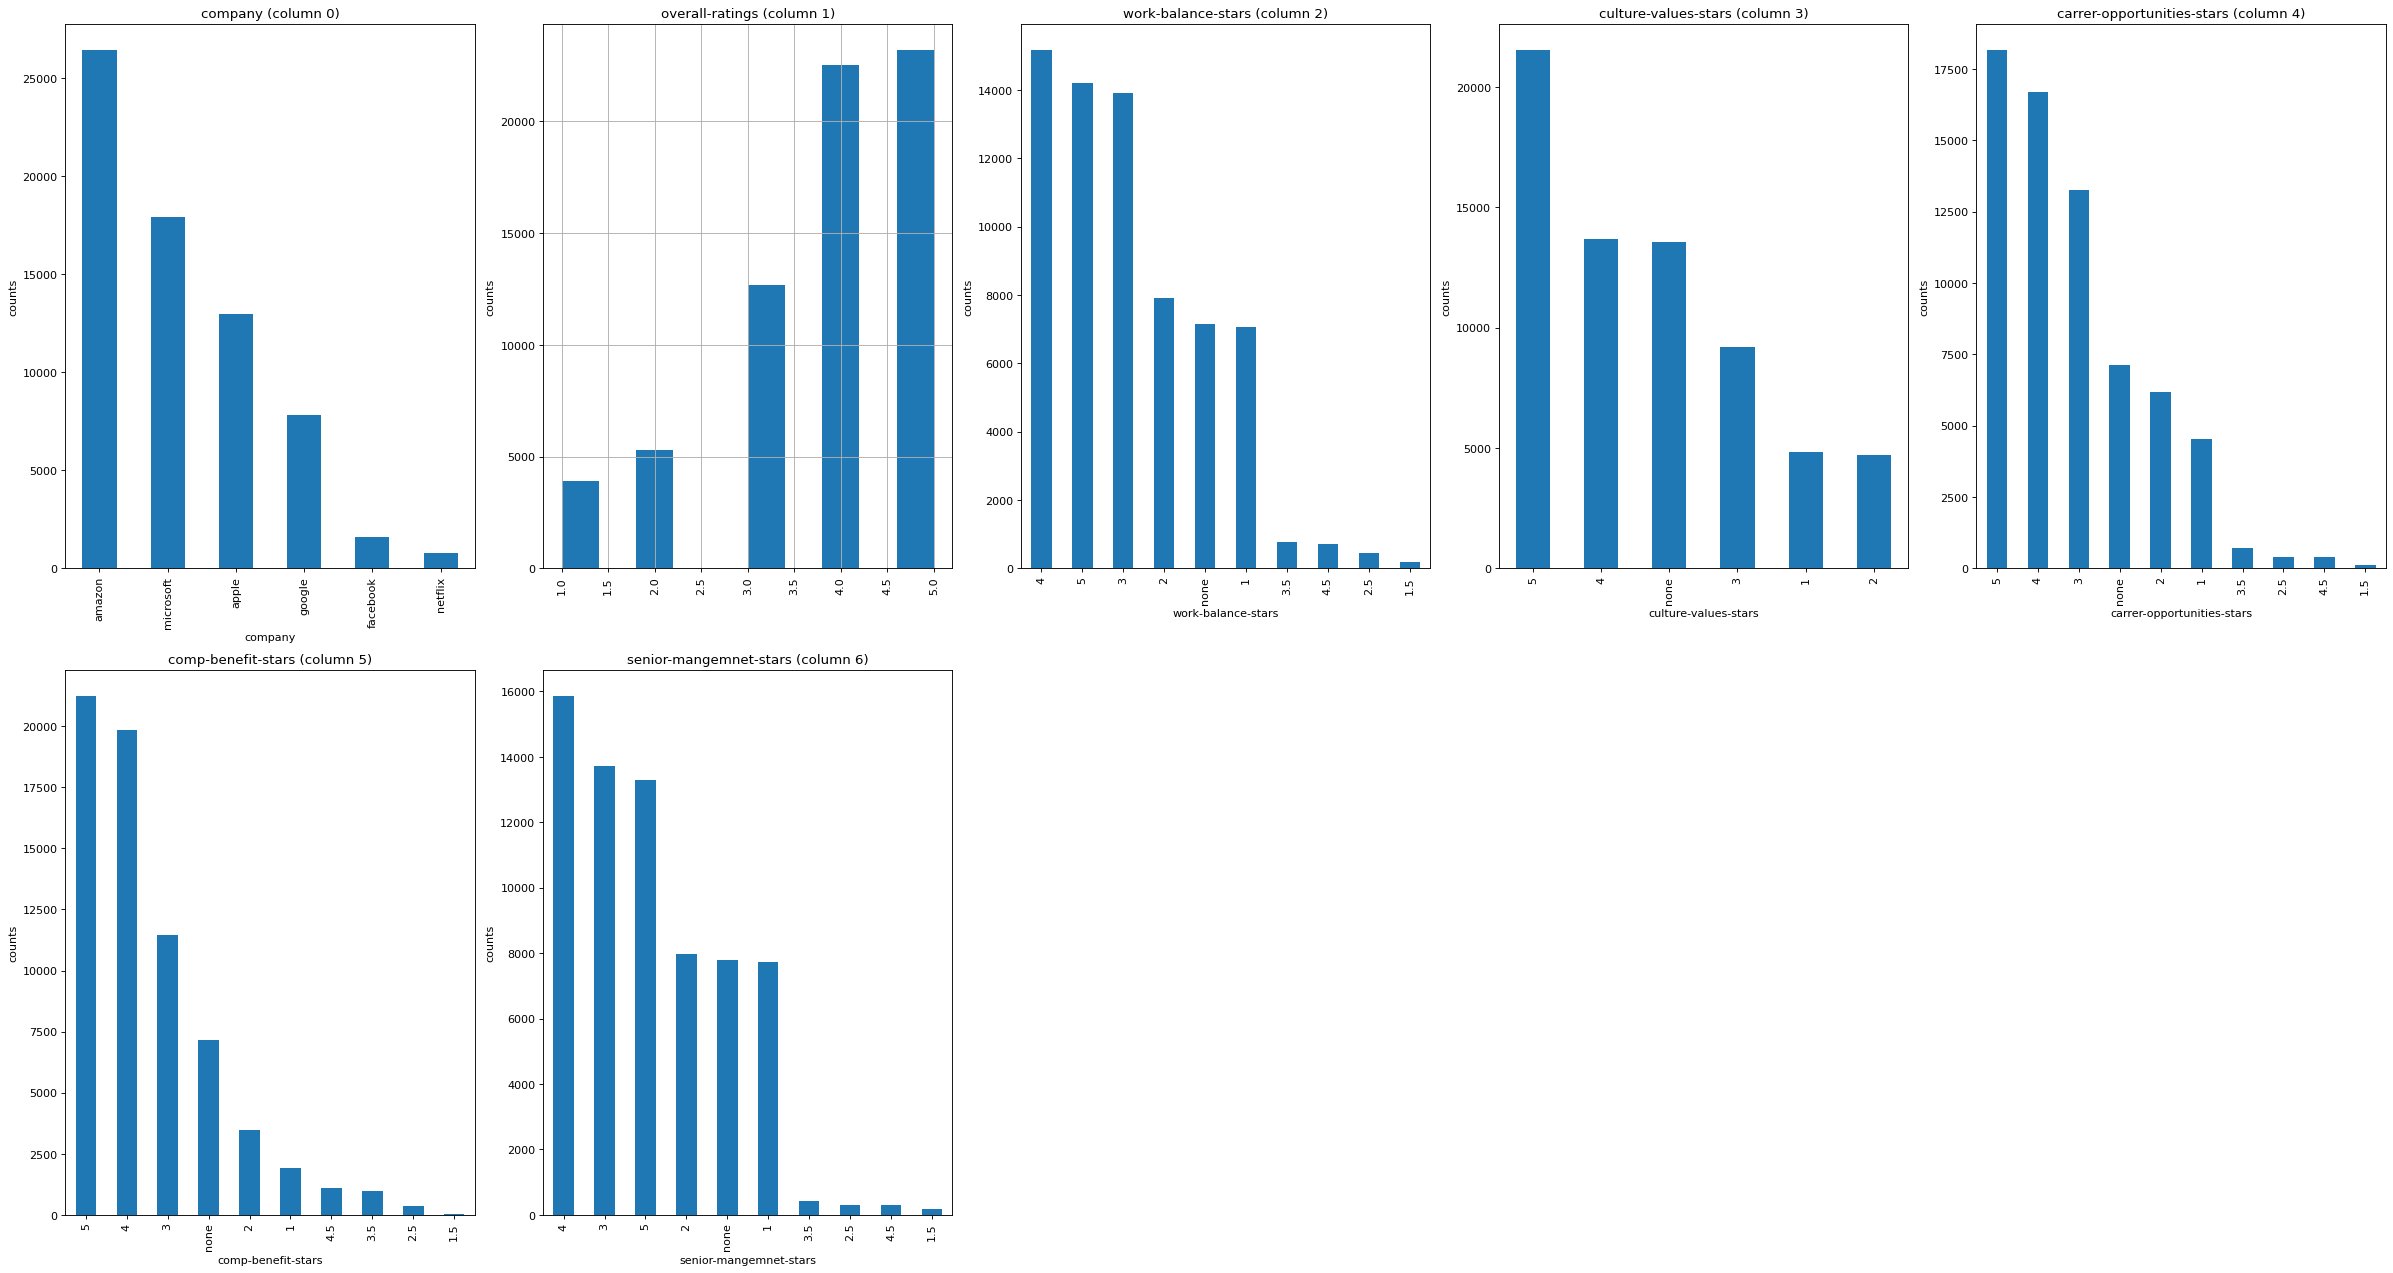

In [9]:
plotPerColumnDistribution(df, 10, 5)

In [10]:
def merge_columns(row):
    return str(row['summary']) + str(row['pros']) + str(row['cons'] + str(row['advice-to-mgmt']))


In [11]:
df['emp_summary'] = df.apply(merge_columns, axis=1)

In [12]:
df.drop(['summary', 'pros', 'cons','advice-to-mgmt'], axis=1, inplace=True)

In [13]:
df.head(5)

,Unnamed: 0,company,location,dates,job-title,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,link,emp_summary
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,5,4,5,5,4,5,https://www.glassdoor.com/Reviews/Google-Revie...,Best Company to work forPeople are smart and f...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,4,2,3,3,5,3,https://www.glassdoor.com/Reviews/Google-Revie...,"Moving at the speed of light, burn out is inev..."
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,5,5,4,5,5,4,https://www.glassdoor.com/Reviews/Google-Revie...,Great balance between big-company security and...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,5,2,5,5,4,5,https://www.glassdoor.com/Reviews/Google-Revie...,The best place I've worked and also the most d...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,5,5,5,5,5,5,https://www.glassdoor.com/Reviews/Google-Revie...,"Unique, one of a kind dream jobGoogle is a wor..."


In [14]:


# Function to perform text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercase conversion
    tokens = [token.lower() for token in tokens]
    
    # Spelling correction
   # corrected_tokens = []
    #for token in tokens:
        #corrected_tokens.append(str(TextBlob(token).correct()))
    
    # Remove numeric values
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # Remove unnecessary data like usernames
    tokens = [re.sub(r'@[^\s]+', '', token) for token in tokens]
    
    # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply text preprocessing to the 'emp_summary' column
df['emp_summary'] = df['emp_summary'].apply(preprocess_text)

# Display the preprocessed column
print(df['emp_summary'])


0        best compani work forpeopl smart friendlyburea...
1        move speed light burn food food food cafe main...
2        great balanc secur fun project softwar engin a...
3        best place work also ca find compani actual de...
4        uniqu one kind dream jobgoogl world everi comp...
                               ...                        
67524    enrich experi beginn bad long term wide rang t...
67525    complex interest microsoft chang role either c...
67526    good place worknic place work good atmospher c...
67527    competit work place overload work item grow po...
67528    use greatcompens health benefit brand name rec...
Name: emp_summary, Length: 67529, dtype: object


In [15]:


# Function to get sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        sentiment = "Positive"
    elif sentiment_score < 0:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return sentiment

# Apply sentiment analysis to the 'emp_summary' column
df['sentiment'] = df['emp_summary'].apply(get_sentiment)

# Display the DataFrame with the new 'sentiment' column
print(df.head())

   Unnamed: 0 company           location          dates  \
0           1  google               none   Dec 11, 2018   
1           2  google  Mountain View, CA   Jun 21, 2013   
2           3  google       New York, NY   May 10, 2014   
3           4  google  Mountain View, CA    Feb 8, 2015   
4           5  google    Los Angeles, CA   Jul 19, 2018   

                                  job-title  overall-ratings  \
0     Current Employee - Anonymous Employee                5   
1         Former Employee - Program Manager                4   
2  Current Employee - Software Engineer III                5   
3     Current Employee - Anonymous Employee                5   
4       Former Employee - Software Engineer                5   

  work-balance-stars culture-values-stars carrer-opportunities-stars  \
0                  4                    5                          5   
1                  2                    3                          3   
2                  5                    4   

In [16]:
df['sentiment'].value_counts()

sentiment
Positive    52789
Negative     7418
Neutral      7322
Name: count, dtype: int64

In [17]:

# Load your dataset and preprocess it if needed
# Assuming your dataset is loaded into a DataFrame named df

# Shuffle the dataset to randomize the order
df = shuffle(df, random_state=42)

# Separate positive, negative, and neutral sentiment samples
positive_samples = df[df['sentiment'] == 'Positive']
negative_samples = df[df['sentiment'] == 'Negative']
neutral_samples = df[df['sentiment'] == 'Neutral']

# Take an equal number of samples from each sentiment
num_samples = min(len(positive_samples), len(negative_samples), len(neutral_samples))
balanced_df = pd.concat([
    positive_samples.head(num_samples),
    negative_samples.head(num_samples),
    neutral_samples.head(num_samples)
])


In [18]:

# Split the balanced dataset into X and y
X = balanced_df['emp_summary']
y = balanced_df['sentiment']


In [19]:

# Split the balanced dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [20]:

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [21]:

# Logistic Regression hyperparameters
lr_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Support Vector Classifier hyperparameters
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# SGDClassifier hyperparameters
sgdc_params = {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['hinge', 'log', 'modified_huber']
}

# Create models
lr = LogisticRegression()
svc = SVC()
sgdc = SGDClassifier()

# Perform GridSearchCV for LR
lr_grid = GridSearchCV(lr, lr_params, cv=5)
lr_grid.fit(X_train_tfidf, y_train)
print("Best LR parameters:", lr_grid.best_params_)

# Perform GridSearchCV for SVC
svc_grid = GridSearchCV(svc, svc_params, cv=5)
svc_grid.fit(X_train_tfidf, y_train)
print("Best SVC parameters:", svc_grid.best_params_)

# Perform GridSearchCV for SGDClassifier
sgdc_grid = GridSearchCV(sgdc, sgdc_params, cv=5)
sgdc_grid.fit(X_train_tfidf, y_train)
print("Best SGDC parameters:", sgdc_grid.best_params_)

# Create Voting Classifier with hard voting
voting_clf = VotingClassifier(estimators=[
    ('lr', lr_grid.best_estimator_),
    ('svc', svc_grid.best_estimator_),
    ('sgdc', sgdc_grid.best_estimator_)
], voting='hard')

# Train the Voting Classifier
voting_clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = voting_clf.predict(X_test_tfidf)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Best LR parameters: {'C': 10, 'solver': 'lbfgs'}
Best SVC parameters: {'C': 10, 'kernel': 'linear'}


C:\Users\parth.parikh1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\parth.parikh1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\parth.parikh1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8

Best SGDC parameters: {'alpha': 0.0001, 'loss': 'modified_huber'}
Accuracy: 0.9380917698470502
Precision: 0.9395439795694674
Recall: 0.9380917698470502


In [23]:
# Save Voting Classifier as a pickle file
joblib.dump(voting_clf, 'employee_review.pkl')

print("Model saved successfully.")

Model saved successfully.


In [24]:
balanced_df['sentiment'].value_counts()

sentiment
Positive    7322
Negative    7322
Neutral     7322
Name: count, dtype: int64

In [25]:
random_string = "I  didnot enjoy the movie. It was bad!"
random_string_tfidf = tfidf_vectorizer.transform([random_string])
predicted_sentiment = voting_clf.predict(random_string_tfidf)
print("Predicted sentiment:", predicted_sentiment[0])

Predicted sentiment: Negative
